# Energy density of the glasma fields
Notebook to visualize the energy density transverse profile throughout the evolution. 


### Default simulation parameters for the Glasma and the Wong solvers.

In [1]:
import numpy as np

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# General parameters
su_group = 'su2'        # Gauge group
# su_group = 'su3' 

# Simulation box parameters
L = 2      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_sim = 0.31     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters
Qs = 1.0              # Saturation momentum [GeV]	
ns = 50    # Number of color sheets
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))   # Running coupling constant    		
mu = g2mu / g**2    # MV model parameter          	
ir = 0.1 * g**2 * mu    # Infrared regulator [GeV]         
uv = 10.0   # Ultraviolet regulator [GeV] 

seed = 314

In [2]:
1/Qs * hbarc

0.197326

### Set environment variables and import all relevant modules.

In [3]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('/n/work00/davrames/curraun-clean/')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
# Energy density
from curraun.energy import Energy

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

Using CUDA
Using SU(2)
Using double precision
Using double precision
Using double precision


### Glasma energy density

In [4]:
from tqdm import tqdm
import pickle

# Derived parameters
a = L / N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)

# Initialize Glasma fields
mv.set_seed(seed)
s = core.Simulation(N, DT, g)
va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
initial.init(s, va, vb)

# Initialize energy computation
energy = Energy(s)
ed = []
ed_el, ed_bl, ed_et, ed_bt = [], [], [], []

taus = [a, 1/Qs * hbarc/2, 1/Qs * hbarc]
taus_index = [int(t / a * DTS) for t in taus]

with tqdm(total=maxt) as pbar:
    for t in range(maxt):
        # Evolve Glasma fields
        core.evolve_leapfrog(s)

        if t in taus_index:
            energy.compute()
            # units [Gev / fm^3]
            units = E0 ** 4 / hbarc ** 3
            el, bl, et, bt = energy.EL.reshape(N, N), energy.BL.reshape(N, N), energy.ET.reshape(N, N), energy.BT.reshape(N, N)
            e = (el+et+bl+bt)/t/g**2
            ed.append(e*units)
            ed_el.append(el/t/g**2*units)
            ed_bl.append(bl/t/g**2*units)
            ed_et.append(et/t/g**2*units)
            ed_bt.append(bt/t/g**2*units)

        pbar.update(1)

CudaAPIError: [2] Call to cuMemAlloc results in CUDA_ERROR_OUT_OF_MEMORY

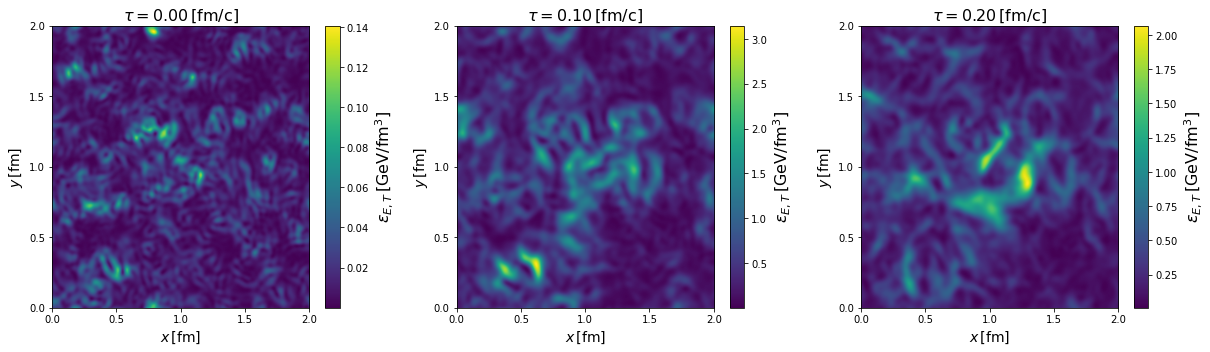

In [98]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, ax in enumerate(axes):
    # cax = ax.imshow(ed[i], cmap='viridis', aspect='auto', extent=[0, L, 0, L])
    cax = ax.imshow(ed_et[i], cmap='viridis', aspect='auto', extent=[0, L, 0, L])
    ax.set_title(r'$\tau = {%.2f}\,\mathrm{[fm/c]}$' % taus[i], size=16)

    ax.set_xlabel(r'$x\,\mathrm{[fm]}$', size=14)
    ax.set_ylabel(r'$y\,\mathrm{[fm]}$', size=14)
    cbar = fig.colorbar(cax, ax=ax, label=r'$\varepsilon_{E, T}\,[\mathrm{GeV}/\mathrm{fm^3}]$')
    cbar.ax.yaxis.label.set_size(16)

    ax.set_xticks(np.linspace(0, L, num=5))
    ax.set_xticklabels(np.linspace(0, L, num=5))
    ax.set_yticks(np.linspace(0, L, num=5))
    ax.set_yticklabels(np.linspace(0, L, num=5))

plt.tight_layout()
plt.savefig('ed_et.png', dpi=600, facecolor='w')
plt.show()

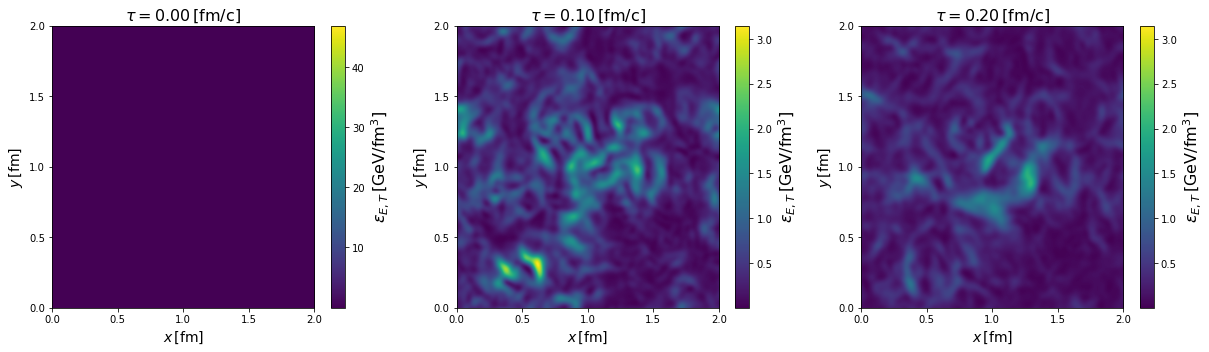

In [93]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, ax in enumerate(axes):
    # cax = ax.imshow(ed[i], cmap='viridis', aspect='auto', extent=[0, L, 0, L])
    if i==1:
        cax = ax.imshow(ed_et[i], cmap='viridis', aspect='auto', extent=[0, L, 0, L])
        vmin, vmax = cax.get_clim()
    else:
        cax = ax.imshow(ed_et[i], cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax, extent=[0, L, 0, L])
    ax.set_title(r'$\tau = {%.2f}\,\mathrm{[fm/c]}$' % taus[i], size=16)

    ax.set_xlabel(r'$x\,\mathrm{[fm]}$', size=14)
    ax.set_ylabel(r'$y\,\mathrm{[fm]}$', size=14)
    cbar = fig.colorbar(cax, ax=ax, label=r'$\varepsilon_{E,T}\,[\mathrm{GeV}/\mathrm{fm^3}]$')
    cbar.ax.yaxis.label.set_size(16)

    ax.set_xticks(np.linspace(0, L, num=5))
    ax.set_xticklabels(np.linspace(0, L, num=5))
    ax.set_yticks(np.linspace(0, L, num=5))
    ax.set_yticklabels(np.linspace(0, L, num=5))

plt.tight_layout()
plt.savefig('ed_et_same_cmap.png', dpi=600, facecolor='w')
plt.show()

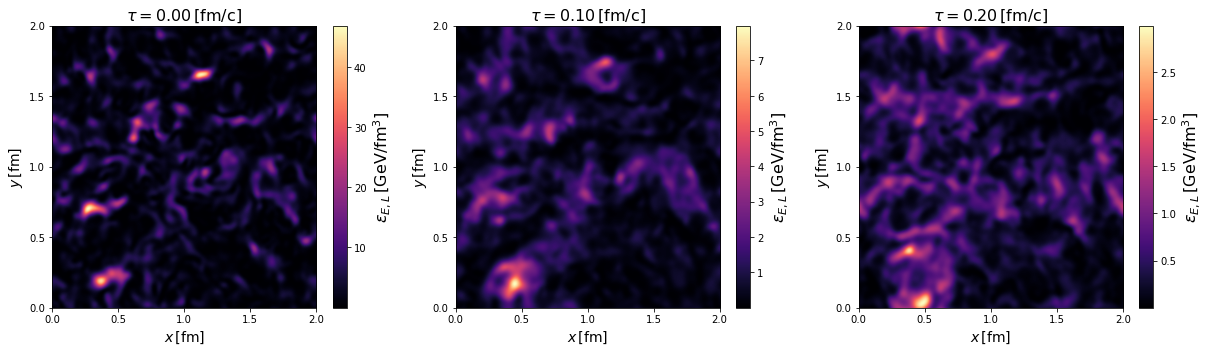

In [94]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, ax in enumerate(axes):
    # cax = ax.imshow(ed[i], cmap='viridis', aspect='auto', extent=[0, L, 0, L])
    cax = ax.imshow(ed_el[i], cmap='magma', aspect='auto', extent=[0, L, 0, L])
    ax.set_title(r'$\tau = {%.2f}\,\mathrm{[fm/c]}$' % taus[i], size=16)

    ax.set_xlabel(r'$x\,\mathrm{[fm]}$', size=14)
    ax.set_ylabel(r'$y\,\mathrm{[fm]}$', size=14)
    cbar = fig.colorbar(cax, ax=ax, label=r'$\varepsilon_{E, L}\,[\mathrm{GeV}/\mathrm{fm^3}]$')
    cbar.ax.yaxis.label.set_size(16)

    ax.set_xticks(np.linspace(0, L, num=5))
    ax.set_xticklabels(np.linspace(0, L, num=5))
    ax.set_yticks(np.linspace(0, L, num=5))
    ax.set_yticklabels(np.linspace(0, L, num=5))

plt.tight_layout()
plt.savefig('ed_el.png', dpi=600, facecolor='w')
plt.show()

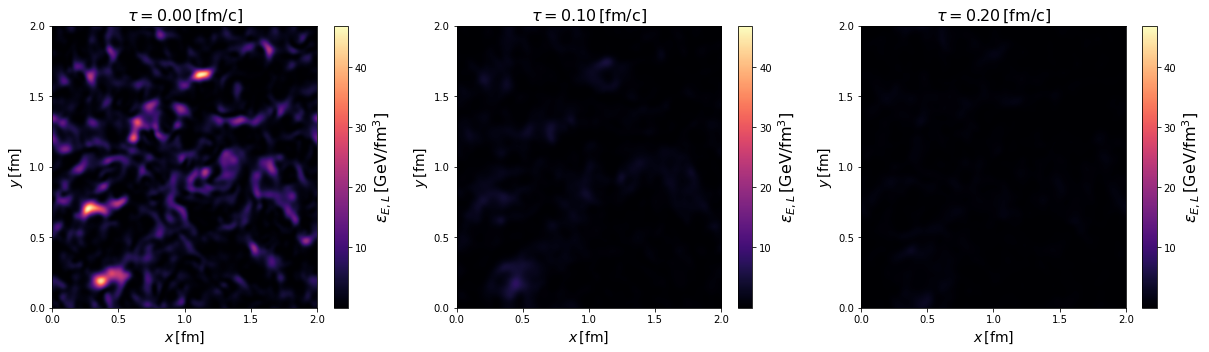

In [95]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, ax in enumerate(axes):
    # cax = ax.imshow(ed[i], cmap='viridis', aspect='auto', extent=[0, L, 0, L])
    if i==0:
        cax = ax.imshow(ed_el[i], cmap='magma', aspect='auto', extent=[0, L, 0, L])
        vmin, vmax = cax.get_clim()
    else:
        cax = ax.imshow(ed_el[i], cmap='magma', aspect='auto', vmin=vmin, vmax=vmax, extent=[0, L, 0, L])
    ax.set_title(r'$\tau = {%.2f}\,\mathrm{[fm/c]}$' % taus[i], size=16)

    ax.set_xlabel(r'$x\,\mathrm{[fm]}$', size=14)
    ax.set_ylabel(r'$y\,\mathrm{[fm]}$', size=14)
    cbar = fig.colorbar(cax, ax=ax, label=r'$\varepsilon_{E,L}\,[\mathrm{GeV}/\mathrm{fm^3}]$')
    cbar.ax.yaxis.label.set_size(16)

    ax.set_xticks(np.linspace(0, L, num=5))
    ax.set_xticklabels(np.linspace(0, L, num=5))
    ax.set_yticks(np.linspace(0, L, num=5))
    ax.set_yticklabels(np.linspace(0, L, num=5))

plt.tight_layout()
plt.savefig('ed_el_same_cmap.png', dpi=600, facecolor='w')
plt.show()

### Plot energy density contributions

In [4]:
from tqdm import tqdm
import pickle
import numpy as np

# Number of events
# num_events = 10
num_events = 1

# Initialize lists to store averages for each event
all_ed_el_avg = []
all_ed_et_avg = []
all_ed_bl_avg = []
all_ed_bt_avg = []
all_ed_avg = []

for event in range(num_events):
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize energy computation
    energy = Energy(s)
    ed_el_avg, ed_et_avg, ed_bl_avg, ed_bt_avg, ed_avg = [], [], [], [], []
    taus_avg = []

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            if t>0:
                # Energy density calculation
                energy.compute()

                units = E0 ** 4 / hbarc ** 4
                ed_el_avg.append(energy.EL_mean * units / t)
                ed_et_avg.append(energy.ET_mean * units / t)
                ed_bl_avg.append(energy.BL_mean * units / t)
                ed_bt_avg.append(energy.BT_mean * units / t)

                # unit factors (Gev / fm^3)
                units = E0 ** 4 / hbarc ** 3
                ed_avg.append(energy.energy_density * units)

                pbar.update(1)
                taus_avg.append(t * a / DTS)

    all_ed_el_avg.append(ed_el_avg)
    all_ed_et_avg.append(ed_et_avg)
    all_ed_bl_avg.append(ed_bl_avg)
    all_ed_bt_avg.append(ed_bt_avg)
    all_ed_avg.append(ed_avg)

# Compute the average over all events
avg_ed_el_avg = np.mean(all_ed_el_avg, axis=0)
avg_ed_et_avg = np.mean(all_ed_et_avg, axis=0)
avg_ed_bl_avg = np.mean(all_ed_bl_avg, axis=0)
avg_ed_bt_avg = np.mean(all_ed_bt_avg, axis=0)
avg_ed_avg = np.mean(all_ed_avg, axis=0)

100%|█████████▉| 633/634 [00:38<00:00, 16.44it/s]


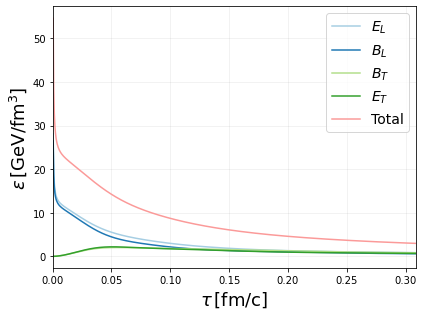

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4.5))

colors = plt.cm.Paired.colors

plt.plot(taus_avg, avg_ed_el_avg, label=r'$E_L$', color=colors[0])
plt.plot(taus_avg, avg_ed_bl_avg, label=r'$B_L$', color=colors[1])
plt.plot(taus_avg, avg_ed_bt_avg, label=r'$B_T$', color=colors[2])
plt.plot(taus_avg, avg_ed_et_avg, label=r'$E_T$', color=colors[3])
# plt.plot(taus_avg, avg_ed_avg, label='avg_ed_avg')
plt.plot(taus_avg, avg_ed_bl_avg+avg_ed_bt_avg+avg_ed_el_avg+avg_ed_et_avg, label='Total', color=colors[4])
plt.legend(fontsize=14)

plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.2)

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size=18)
plt.ylabel(r'$\varepsilon\,[\mathrm{GeV}/\mathrm{fm^3}]$', size=18)
plt.xlim([0, max(taus_avg)])

plt.tight_layout()
plt.savefig('ed_avg_comp.png', dpi=600, facecolor='w')
plt.show()

---
# Glasma field correlators
Extract $\langle E_z(\vec{x}_\perp)E_z(\vec{y}_\perp)\rangle x$ gauge inariant along a light-like jet trajectory.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3,4,5,6"

In [1]:
import warnings
from numba import NumbaPerformanceWarning

# Ignore NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

In [2]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
# os.environ["MY_NUMBA_TARGET"] = "numba"
# os.environ["GAUGE_GROUP"] = "su3"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

# Import curraun and other packages
import sys
# sys.path.append('..')
sys.path.append('/n/work00/davrames/curraun-clean/')

import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.qhat_correlators import JetFieldsCorrelators

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle
from tqdm import tqdm


Using CUDA
Using SU(2)
Using double precision
Using double precision
Using double precision


In [3]:
import numpy as np

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# Simulation box parameters
L = 2      # Length of simulation box [fm]
N = 1024     # Number of lattice sites
DTS = 8     # Time step

# N = 128     # Number of lattice sites
# DTS = 4     # Time step
n_events = 1        # Number of events

# MV model parameters
Qs = 2.0        # Saturation scale [GeV]       
NS = 50     # Number of color sheets
factor = 0.8        # Qs/g2mu ratio from Lappi, for Ns=50 sheets
g2mu = Qs / factor      # MV model parameter times squared coupling [GeV]     
G = np.pi * np.sqrt(1 / np.log(Qs / 0.2))       # Running coupling constant	          		
MU = g2mu / G**2        # MV model parameter         	
M = 0.1 * G**2 * MU     # Intrared regulator [GeV]        
UV = 10.0       # Ultraviolet regulator [GeV] 

# taus = [0.01, 0.05, 0.1, 0.15, 0.3, 0.5]     # Formation times [GeV/fm]
# taus = [0.01, 0.02, 0.05, 0.1, 0.3, 0.5]
tau_max = 0.4    # Simulation time [GeV/fm]

In [4]:
# Define hbar*c [GeV*fm]
hbarc = 0.197326 

# def simulate():    
# Derived parameters
a = L / N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int((tau_max ) / a) * DTS

s = core.Simulation(N, DT, G)
mv.set_seed(124)
va = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
vb = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
initial.init(s, va, vb)

# output = {}

fields = JetFieldsCorrelators(s)

if use_cuda:
    s.copy_to_device()

delta_tau = np.zeros(maxt // DTS)

elcorr = np.zeros((maxt // DTS, 3))
elcorr_all = np.zeros((maxt // DTS, N*N, 3))

magcorr = np.zeros((maxt // DTS, 3))
magcorr_all = np.zeros((maxt // DTS, N*N, 3))

for t in range(maxt):
    core.evolve_leapfrog(s)
    
    if t % DTS == 0:
        EE_all, BB_all = fields.compute_corr()

        units = E0 ** 4

        # EE_all = fields.compute_elcorr()
        elcorr_all[t//DTS] = np.multiply(EE_all, units)

        EE = np.mean(EE_all, axis=0)
        EE *= units
        elcorr[t//DTS] = EE

        # BB_all = fields.compute_magcorr()
        magcorr_all[t//DTS] = np.multiply(BB_all, units)

        BB = np.mean(BB_all, axis=0)
        BB *= units
        magcorr[t//DTS] = BB

        delta_tau[t//DTS] = t / DTS * a
        
# output['tau'], output['elcorr'], output['magcorr']  = delta_tau, elcorr, magcorr
        
    # return output

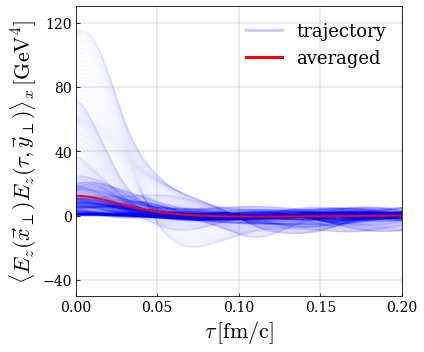

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

plt.plot(delta_tau, elcorr_all[:, 0:N, 2], color='blue', alpha=0.02, linewidth=1.5)
plt.plot(delta_tau, elcorr[:, 2], color='red', linewidth=2)


plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle E_z(\vec{x}_\perp)E_z(\tau, \vec{y}_\perp)\rangle_x\,\mathrm{[GeV^4]}$', fontsize=22)
# plt.title(r'$elcorr$ as a function of $\Delta \tau$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.xlim([0, 0.3])
plt.xlim([0, 0.2])
plt.ylim([-50, 130])
plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
plt.yticks([-40, 0, 40, 80, 120])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend_handles = [
    Line2D([0], [0], color='blue', alpha=0.2, linewidth=3, label='trajectory'),
    Line2D([0], [0], color='red', linewidth=3, label='averaged') 
]
plt.legend(handles=legend_handles, fontsize=18, frameon=False)

plt.tight_layout()

# plt.savefig('ezcorr_lightlike.png', dpi=900, facecolor='w')
plt.savefig('ezcorr_lightlike.pdf', facecolor='w')

plt.show()

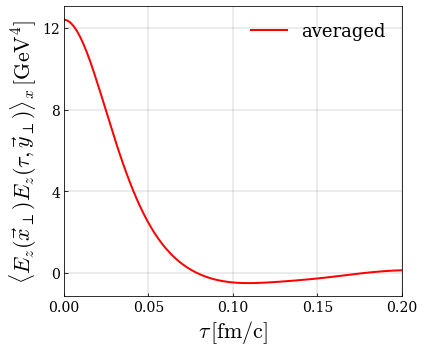

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

# plt.plot(delta_tau, elcorr_all[:, 0:N, 2], color='blue', alpha=0.02, linewidth=1.5)
plt.plot(delta_tau, elcorr[:, 2], color='red', linewidth=2, label='averaged')


plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle E_z(\vec{x}_\perp)E_z(\tau, \vec{y}_\perp)\rangle_x\,\mathrm{[GeV^4]}$', fontsize=22)
# plt.title(r'$elcorr$ as a function of $\Delta \tau$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.xlim([0, 0.3])
plt.xlim([0, 0.2])
# plt.ylim([-50, 130])
plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
plt.yticks([0, 4, 8, 12])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

# legend_handles = [
#     # Line2D([0], [0], color='blue', alpha=0.2, linewidth=3, label='trajectory'),
#     Line2D([0], [0], color='red', linewidth=3, label='averaged') 
# ]
plt.legend(fontsize=18, frameon=False)

plt.tight_layout()

# plt.savefig('ezcorr_lightlike_avg.png', dpi=900, facecolor='w')
plt.savefig('ezcorr_lightlike_avg.pdf', facecolor='w')

plt.show()

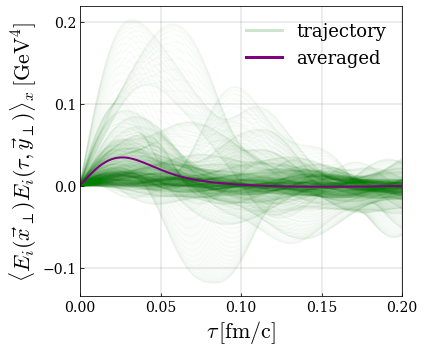

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

# plt.plot(delta_tau, magcorr_all[:, 0:N, 2], color='green', alpha=0.02, linewidth=1.5)
# plt.plot(delta_tau, magcorr[:, 2], color='purple', linewidth=2)

plt.plot(delta_tau, 2 * elcorr_all[:, 0:N, 0], color='green', alpha=0.02, linewidth=1.5)
plt.plot(delta_tau, 2 * elcorr[:, 0], color='purple', linewidth=2)


plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle E_i(\vec{x}_\perp)E_i(\tau, \vec{y}_\perp)\rangle_x\,\mathrm{[GeV^4]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 0.2])
# plt.ylim([-50, 130])
plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
plt.yticks([-0.1, 0, 0.1, 0.2])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend_handles = [
    Line2D([0], [0], color='green', alpha=0.2, linewidth=3, label='trajectory'),
    Line2D([0], [0], color='purple', linewidth=3, label='averaged') 
]
plt.legend(handles=legend_handles, fontsize=18, frameon=False)

plt.tight_layout()

# plt.savefig('bzcorr_lightlike.png', dpi=900, facecolor='w')
plt.savefig('eicorr_lightlike.pdf', facecolor='w')

plt.show()

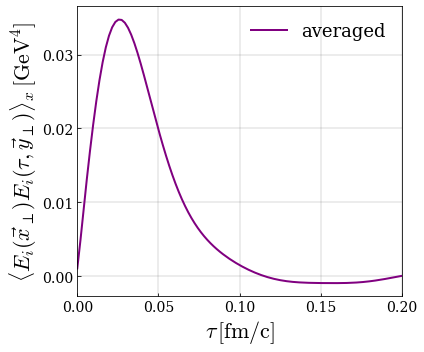

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

plt.plot(delta_tau, 2 * elcorr[:, 0], color='purple', linewidth=2, label='averaged')


plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle E_i(\vec{x}_\perp)E_i(\tau, \vec{y}_\perp)\rangle_x\,\mathrm{[GeV^4]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 0.2])
# plt.ylim([-50, 130])
plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
plt.yticks([0, 0.01, 0.02, 0.03])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

plt.legend(fontsize=18, frameon=False)

plt.tight_layout()

# plt.savefig('bzcorr_lightlike_avg.png', dpi=900, facecolor='w')
plt.savefig('eicorr_lightlike_avg.pdf', facecolor='w')

plt.show()

---
Classical $\hat{q}$ with or without transverse components

In [1]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

import sys
sys.path.append('/n/work00/davrames/curraun-clean/')

import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle
from tqdm import tqdm

from curraun.qhat import TransportedForce
from curraun.qhat_correlators import LongTransportedForce

Using CUDA
Using SU(2)
Using double precision
Using double precision
Using double precision


In [2]:
# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# Simulation box parameters
L = 2      # Length of simulation box [fm]
N = 1024     # Number of lattice sites
DTS = 8     # Time step

# N = 128     # Number of lattice sites
# DTS = 4     # Time step
n_events = 1        # Number of events

# MV model parameters
Qs = 2.0        # Saturation scale [GeV]       
NS = 50     # Number of color sheets
factor = 0.8        # Qs/g2mu ratio from Lappi, for Ns=50 sheets
g2mu = Qs / factor      # MV model parameter times squared coupling [GeV]     
G = np.pi * np.sqrt(1 / np.log(Qs / 0.2))       # Running coupling constant	          		
MU = g2mu / G**2        # MV model parameter         	
M = 0.1 * G**2 * MU     # Intrared regulator [GeV]        
UV = 10.0       # Ultraviolet regulator [GeV] 

# taus = [0.01, 0.05, 0.1, 0.15, 0.3, 0.5]     # Formation times [GeV/fm]
# taus = [0.01, 0.02, 0.05, 0.1, 0.3, 0.5]
tau_max = 1.0    # Simulation time [GeV/fm]

In [3]:
def simulate_qhat(ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_max / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, G)
    mv.set_seed(124)
    va = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
    vb = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
    initial.init(s, va, vb)

    # Initialize the Qhat module
    qhat = TransportedForce(s)
    qhat_long = LongTransportedForce(s)
    mom_broad, mom_broad_long, tau =  [], [], []

    if use_cuda:
        qhat.copy_to_device()
        qhat_long.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Compute momentum broadening from Qhat module
            if t % DTS == 0:
                if use_cuda:
                    qhat.copy_mean_to_host()
                    qhat_long.copy_mean_to_host()

                # Units GeV^2
                mom_broad.append(qhat.p_perp_mean * E0 ** 2)
                mom_broad_long.append(qhat_long.p_perp_mean * E0 ** 2)

                tau.append(t / DTS * a)
                
                if use_cuda:
                    qhat.copy_mean_to_device()
                    qhat_long.copy_mean_to_device()
            qhat.compute()
            qhat_long.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad, mom_broad_long, tau

In [4]:
nevents = 10

mom_broads, mom_broads_long = [], []
for ev in range(nevents):
    mom_broad_ev, mom_broad_long_ev, tau = simulate_qhat(ev)
    mom_broads.append(mom_broad_ev)
    mom_broads_long.append(mom_broad_long_ev)

mom_broad = np.mean(mom_broads, axis=0)
mom_broad_long = np.mean(mom_broads_long, axis=0)

Event 4:  38%|███▊      | 1555/4096 [03:38<05:56,  7.12it/s]


KeyboardInterrupt: 

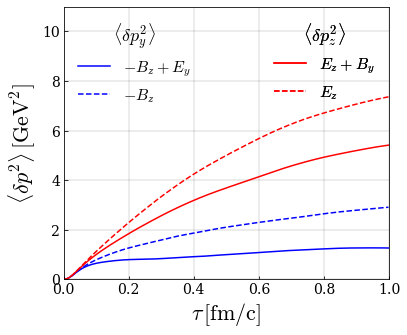

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

labels = [r'$E_y-B_z$', r'$E_z+B_y$']
labels_long = [r'$-B_z$', r'$E_z$']
colors = ['blue', 'red']

for i in [1,2]:
    plt.plot(tau, mom_broad[:, i], color=colors[i-1])
    plt.plot(tau, mom_broad_long[:, i], color=colors[i-1], linestyle='--')

# plt.plot(xplus, mom_broad[:, 1] + mom_broad[:, 2], label="y+z")

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle \delta p^2\rangle\,\mathrm{[GeV^2]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 1.0])
plt.ylim([0, 11])
# plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
# plt.yticks([0, 0.01, 0.02, 0.03])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

# plt.legend(fontsize=18, frameon=False)

legend1 = plt.legend(handles=[plt.Line2D([0], [0], color='blue', linestyle='-', label=r'$-B_z+E_y$'),
                              plt.Line2D([0], [0], color='blue', linestyle='--', label=r'$-B_z$')],
                     title=r'$\langle \delta p^2_y\rangle$', fontsize=16, frameon=False, loc='upper left')

plt.gca().add_artist(legend1)

legend2 = plt.legend(handles=[plt.Line2D([0], [0], color='red', linestyle='-', label=r'$E_z+B_y$'),
                              plt.Line2D([0], [0], color='red', linestyle='--', label=r'$E_z$')],
                     title=r'$\langle \delta p^2_z\rangle$', fontsize=16, frameon=False, loc='upper right')

plt.gca().add_artist(legend2)

plt.tight_layout()

# plt.savefig('mom_broad_eb_contrib.pdf', facecolor='w')

plt.show()

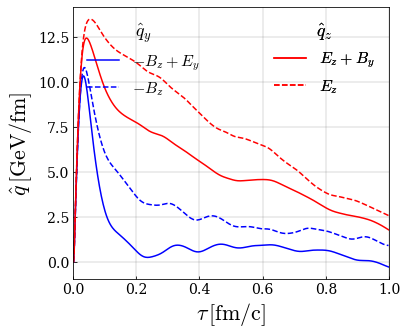

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

labels = [r'$E_y-B_z$', r'$E_z+B_y$']
labels_long = [r'$-B_z$', r'$E_z$']
colors = ['blue', 'red']

for i in [1,2]:
    qhat = np.diff(mom_broad[:, i]) / np.diff(tau)
    plt.plot(tau[1:len(tau)], qhat, color=colors[i-1])
    
    qhat_long = np.diff(mom_broad_long[:, i]) / np.diff(tau)
    plt.plot(tau[1:len(tau)], qhat_long, color=colors[i-1], linestyle='--')

# plt.plot(xplus, mom_broad[:, 1] + mom_broad[:, 2], label="y+z")

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\hat{q}\,\mathrm{[GeV/fm]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 1.0])
# plt.ylim([0, 11])
# plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
# plt.yticks([0, 0.01, 0.02, 0.03])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

# plt.legend(fontsize=18, frameon=False)

legend1 = plt.legend(handles=[plt.Line2D([0], [0], color='blue', linestyle='-', label=r'$-B_z+E_y$'),
                              plt.Line2D([0], [0], color='blue', linestyle='--', label=r'$-B_z$')],
                     title=r'$\hat{q}_y$', fontsize=16, frameon=False, loc='upper left')

plt.gca().add_artist(legend1)

legend2 = plt.legend(handles=[plt.Line2D([0], [0], color='red', linestyle='-', label=r'$E_z+B_y$'),
                              plt.Line2D([0], [0], color='red', linestyle='--', label=r'$E_z$')],
                     title=r'$\hat{q}_z$', fontsize=16, frameon=False, loc='upper right')

plt.gca().add_artist(legend2)

plt.tight_layout()

# plt.savefig('qhat_eb_contrib.pdf', facecolor='w')

plt.show()

---
To remove

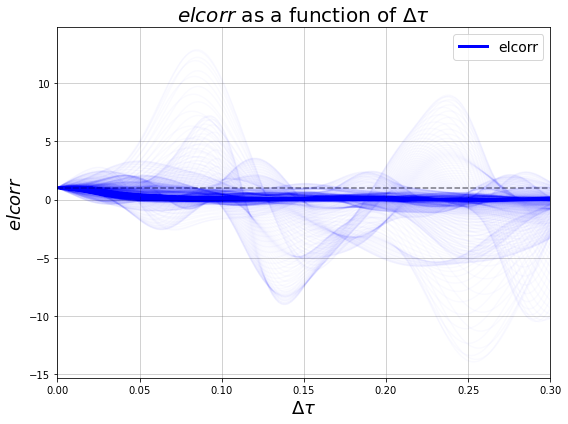

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
# delta_tau = np.linspace(0, 1, 100)  # Replace with your actual delta_tau data
# elcorr = np.random.rand(100)  # Replace with your actual elcorr data

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(delta_tau, elcorr[:, 2]/elcorr[0, 2], label='elcorr', color='blue', linewidth=3)
plt.plot(delta_tau, np.ones(len(delta_tau)), color='gray', linestyle='--')

# plt.plot(delta_tau, elcorr_all[:, 0:N//2, 2], color='blue', alpha=0.02)
# plt.plot(delta_tau, elcorr_all[:, (N//2):N, 2], color='blue', alpha=0.02)
plt.plot(delta_tau, elcorr_all[:, 0:N, 2]/elcorr_all[0, 0:N, 2], color='blue', alpha=0.02)
# plt.plot(delta_tau, elcorr_all[:, :, 2], color='blue', alpha=0.01)

# Set axis labels and title
plt.xlabel(r'$\Delta \tau$', fontsize=18)
plt.ylabel(r'$elcorr$', fontsize=18)
plt.title(r'$elcorr$ as a function of $\Delta \tau$', fontsize=20)
plt.xlim([0, 0.3])

# Add grid
plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.7)

# Add legend
plt.legend(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()